In [1]:
import cv2
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import zipfile
import io
import matplotlib.pyplot as plt
import random
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Add, concatenate, TimeDistributed, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Unzip the dataset
zip_file_path = '/content/drive/MyDrive/Flickr8k/Flickr8k.zip'
unzip_dir = '/content/Flickr8k'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Set the path to the Flickr8K dataset in Google Drive
dataset_path = '/content/Flickr8k'

# Set the path to save the preprocessed data
save_path = '/content/preprocessed_data'

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
# Read the captions file into a Pandas DataFrame
captions_path = os.path.join(dataset_path, 'captions.txt')
df = pd.read_csv(captions_path, sep=',', header=None, names=['image', 'caption'])

df.head()

,image,caption
0,image,caption
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...


In [4]:

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
    return text

# Preprocess the text and save the results
df['caption'] = df['caption'].apply(preprocess_text)

# Create the preprocessed_data directory if it doesn't exist
if not os.path.exists(os.path.join(save_path, 'preprocessed_data')):
    os.makedirs(os.path.join(save_path, 'preprocessed_data'))

# Save the preprocessed captions
new_text_path = os.path.join(save_path, 'new_captions.txt')
df.to_csv(new_text_path, index=False)


In [6]:
# Define data augmentation parameters using ImageDataGenerator
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20
)

# Function to preprocess image with data augmentation
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (224, 224))
    augmented_image = data_augmentation.random_transform(resized_image)
    normalized_image = augmented_image / 255.0
    return normalized_image

# Function to preprocess all images with data augmentation and save them locally
def preprocess_all_images(dataset_path, save_path):
    for file in os.listdir(os.path.join(dataset_path, 'Images')):
        if file.endswith('.jpg'):
            image_path = os.path.join(dataset_path, 'Images', file)
            preprocessed_image_path = os.path.join(save_path, file)
            preprocessed_image = preprocess_image(image_path)
            cv2.imwrite(preprocessed_image_path, (preprocessed_image * 255).astype(np.uint8))

In [7]:
# Display the first 5 random images before and after preprocessing
def display_images(dataset_path, save_path, num_images=5):
    image_files = [file for file in os.listdir(os.path.join(dataset_path, 'Images')) if file.endswith('.jpg')]
    random_images = random.sample(image_files, num_images)
    for file in random_images:
        image_path = os.path.join(dataset_path, 'Images', file)
        preprocessed_image_path = os.path.join(save_path, file)
        original_image = cv2.imread(image_path)
        preprocessed_image = preprocess_image(image_path)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(preprocessed_image, cmap='gray')
        plt.title('Preprocessed Image')
        plt.show()


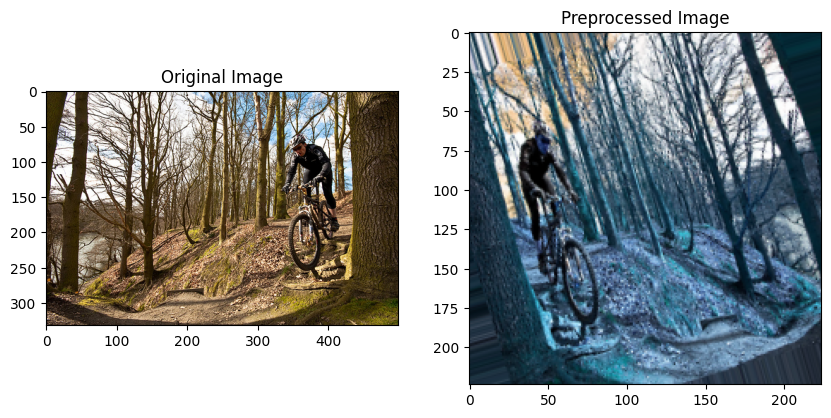

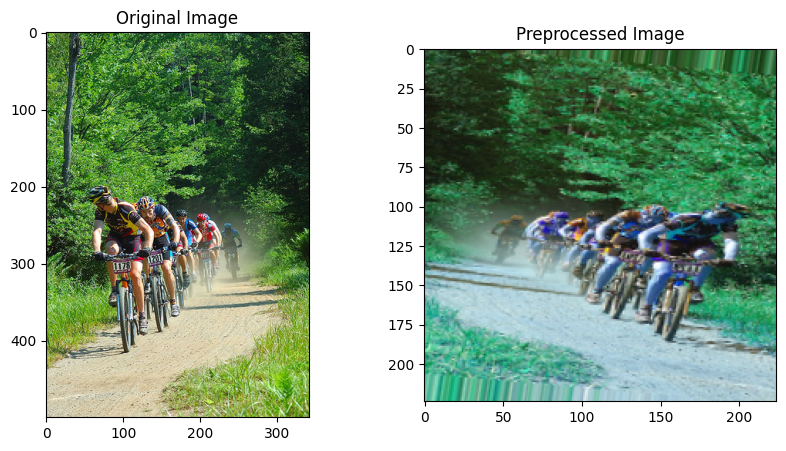

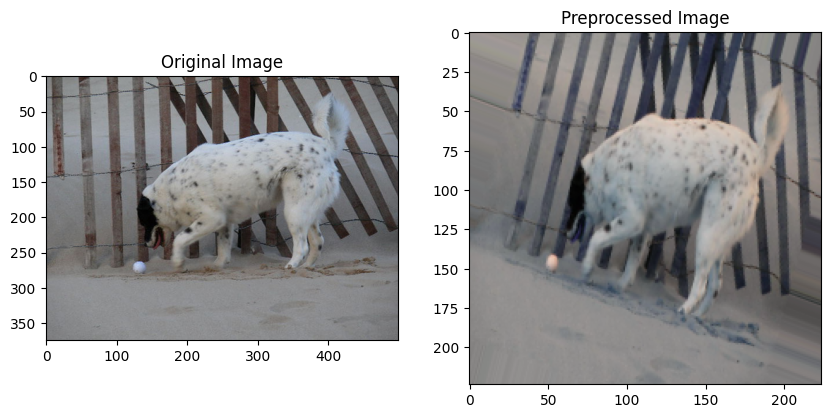

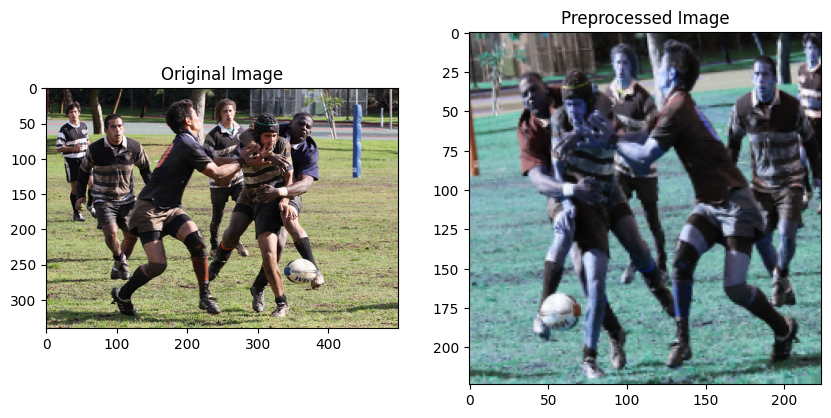

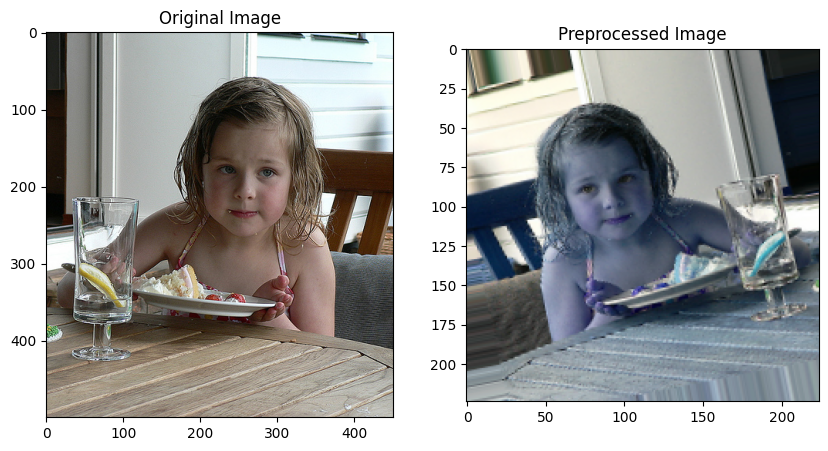

In [8]:
# Preprocess and save all images
preprocess_all_images(dataset_path, save_path)

# Display preprocessed images
display_images(dataset_path, save_path, num_images=5)

In [9]:
# Split dataset into train, validation, and test sets
train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.33, random_state=42)

# Load InceptionV3 model pretrained on ImageNet without top layers
image_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

87910968/87910968 [==============================] - 1s 0us/step


In [10]:

# Create the preprocessed_data directory if it doesn't exist
if not os.path.exists(os.path.join(save_path, 'preprocessed_data')):
    os.makedirs(os.path.join(save_path, 'preprocessed_data'))

# Preprocess and save all images
preprocess_all_images(dataset_path, save_path)



In [11]:
# Function to extract image features
def extract_image_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (299, 299))
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    features = image_model.predict(img)
    return features

# Extract image features and save them to a dictionary
image_features = {}
for img_name in os.listdir(os.path.join(dataset_path, 'Images')):
    if img_name.endswith('.jpg'):
        img_path = os.path.join(dataset_path, 'Images', img_name)
        image_features[img_name] = extract_image_features(img_path)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step


In [12]:
# Tokenize captions
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_df['caption'].values)
vocab_size = len(tokenizer.word_index) + 1

# Generate sequences of tokens from captions
train_sequences = tokenizer.texts_to_sequences(train_df['caption'].values)
val_sequences = tokenizer.texts_to_sequences(val_df['caption'].values)
test_sequences = tokenizer.texts_to_sequences(test_df['caption'].values)

In [13]:
# Pad sequences to maximum length
max_len = max([len(seq) for seq in train_sequences])
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')
val_padded_sequences = pad_sequences(val_sequences, maxlen=max_len, padding='post')
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post')

# Define caption input
caption_input = Input(shape=(max_len,))
caption_features = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(caption_input)
caption_features = LSTM(256)(caption_features)

# Define image input
image_input = Input(shape=(2048,))  # Assuming InceptionV3 output shape
image_features = Dense(256, activation='relu')(image_input)

# Combine image and caption features
decoder = concatenate([image_features, caption_features])
decoder = Dense(256, activation='relu')(decoder)
decoder = Dropout(0.5)(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder)

# Define the model
model = Model(inputs=[image_input, caption_input], outputs=outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 20, 256)              1650176   ['input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 256)                  524544    ['input_3[0][0]']             
                                                                                              

In [ ]:
# Create a mapping from image filename to feature index
image_name_to_index = {img_name: idx for idx, img_name in enumerate(train_df['image'])}

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    [np.array([image_features[image_name_to_index[img]] for img in train_df['image']]), train_padded_sequences],
    train_padded_sequences,
    validation_data=([np.array([image_features[image_name_to_index[img]] for img in val_df['image']]), val_padded_sequences], val_padded_sequences),
    epochs=10,
    batch_size=32,
    verbose=1 ,
    callbacks=[early_stopping]

)

# Save the trained model
model.save('/content/drive/MyDrive/image_captioning_model.h5')

# Plotting training & validation accuracy/loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
